# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

E:\Arpit\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#__doc__ file
"""Sampling 6k datapoints for preprocessing"""
final=final[0:6000]
print(__doc__)
final.shape

Sampling 6k datapoints for preprocessing


(6000, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

1.1410879132164606

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(6000, 10)


1    4979
0    1021
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have removed in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 6000/6000 [00:01<00:00, 3786.96it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

#Drop Deduplication of entries in Summary field
Summary=sorted_data.drop_duplicates(subset={"Summary"}, keep='first', inplace=False)
#__doc__ file
"""Sampling 6k datapoints for preprocessing"""
Summary=Summary[0:6000]
print(__doc__)
Summary.shape


Sampling 6k datapoints for preprocessing


(6000, 10)

In [25]:
# printing some random summary
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)

EVERY book is educational
Shipment was expired by 2 years
Would be best if Canola Oil was left out
Best SF Syrup on the market!


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

EVERY book is educational


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
summ = soup.get_text()
print(summ)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
summ = soup.get_text()
print(summ)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
summ = soup.get_text()
print(summ)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
summ = soup.get_text()
print(summ)

EVERY book is educational
Shipment was expired by 2 years
Would be best if Canola Oil was left out
Best SF Syrup on the market!


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_0 = decontracted(sent_0)
print(sent_0)
print("="*50)

sent_1000 = decontracted(sent_1000)
print(sent_1000)
print("="*50)

sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

sent_4900 = decontracted(sent_4900)
print(sent_4900)
print("="*50)

EVERY book is educational
Shipment was expired by 2 years
Would be best if Canola Oil was left out
Best SF Syrup on the market!


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)
print("="*50)

sent_1000 = re.sub("\S*\d\S*", "", sent_1000).strip()
print(sent_1000)
print("="*50)

sent_1500 = re.sub("\S*\d\S*", "", sent_1500).strip()
print(sent_1500)
print("="*50)

sent_4900 = re.sub("\S*\d\S*", "", sent_4900).strip()
print(sent_4900)
print("="*50)

EVERY book is educational
Shipment was expired by  years
Would be best if Canola Oil was left out
Best SF Syrup on the market!


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_0 = re.sub('[^A-Za-z0-9]+', ' ', sent_0)
print(sent_0)
print("="*50)

sent_1000 = re.sub('[^A-Za-z0-9]+', ' ', sent_1000)
print(sent_1000)
print("="*50)

sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)
print("="*50)

sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)
print("="*50)

EVERY book is educational
Shipment was expired by years
Would be best if Canola Oil was left out
Best SF Syrup on the market 


In [32]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 'w', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'no', 'were', 'these', 'their', 'down', "you've", 'yours', 'himself', "she's", 'as', 'so', 'a', 'shouldn', 'do', 'or', "weren't", 'yourself', "isn't", 'during', "didn't", 'our', "hadn't", 'him', 'with', 'on', 'too', 'aren', 'couldn', "wouldn't", 'that', 'most', 'up', "needn't", 'wasn', 'some', 'then', 'she', 'having', 'had', 'whom', 'has', 'off', 'ain', 'theirs', 'which', 'once', 'there', 'o', 'won', "you're", 'few', 'out', 'when', 'your', 'at', 'did', 'should', 'into', 'very', 'ours', 'over', 'd', 'isn', 'them', 'by', 'her', "wasn't", 'doesn', 'again', 'can', 'haven', "haven't", 'above', 'was', 'here', "it's", 'who', 'those', "that'll", "shouldn't", 'have', 'been', 'itself', 'don', 'under', 'if', 'both', 'all', 've', 'am', 'me', 'the', 'i', 'in', 'of', 'll', 'you', 'are', "should've", 'each', 'while', 'will', 'but', 's', 't', 'weren', 'after', 'now', 'myself', 'through', 'to', 'my', 'how', 'his', 'hasn', 'below', 'doing', "you'd", 'mustn', 'than', 'y', 'because', 'own', 'hers', 'need

In [34]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i = 0
    final_string=[]
    final_summary=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    
    for i, sent in enumerate(tqdm(final['Summary'].values)):
        filtered_summary =[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_summary.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else: 
                    continue
                    str0 = b" ".join(filtered_summary) #final string of cleaned words
        final_summary.append(str0)
        i += 1
                    
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else: 
                    continue
        
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)
        i += 1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        
    
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

# [4] Featurization

## [4.1] BAG OF WORDS

In [35]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

#final_counts = count_vect.transform(preprocessed_reviews)
final_counts = count_vect.fit_transform(final['Text'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aaaaa', 'aaah', 'aafco', 'ab', 'abandon', 'abandoned', 'abdomen', 'abdominal', 'aberration', 'abide']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 18016)
the number of unique words  18016


In [36]:
reviews_label = final['Score']

## [4.2] Bi-Grams and n-Grams.

In [37]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 4268)
the number of unique words including both unigrams and bigrams  4268


## [4.3] TF-IDF

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best', 'absolutely love', 'absolutely loves']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (6000, 4268)
the number of unique words including both unigrams and bigrams  4268


## [4.4] Word2Vec

In [39]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [40]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('quality', 0.9816586971282959), ('pastes', 0.9744594097137451), ('even', 0.9736347198486328), ('good', 0.9721119403839111), ('feel', 0.9716343879699707), ('looking', 0.9706213474273682), ('likes', 0.9700664281845093), ('else', 0.9699466228485107), ('value', 0.9687541127204895), ('overpowering', 0.968704104423523)]
[('track', 0.9995039701461792), ('neither', 0.9994925260543823), ('coat', 0.9994497895240784), ('various', 0.9994394183158875), ('developed', 0.9993937611579895), ('show', 0.9993774890899658), ('chinese', 0.9993691444396973), ('mostly', 0.9993667602539062), ('agree', 0.9993533492088318), ('test', 0.999335765838623)]


In [41]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5289
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'grew', 'reading', 'sendak', 'books', 'watching', 'really', 'movie', 'loves', 'however', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsy', 'takes', 'two', 'hands', 'keep', 'open', 'fun', 'way', 'children', 'learn', 'months']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 6000/6000 [00:05<00:00, 1037.71it/s]


6000
50


#### [4.4.1.2] TFIDF weighted W2v

In [43]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [00:30<00:00, 193.66it/s]


# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

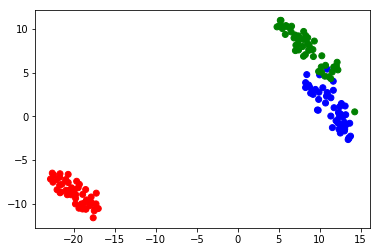

In [45]:
# https://github.com/pavlin-policar/fastTSNE
import numpy as np
from openTSNE import TSNE
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris['data'], iris['target']

tsne = TSNE( n_components=2, perplexity=30, learning_rate=200, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=750)

X_embedding = tsne.fit(x)

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

## [5.1] Applying TNSE on Text BOW vectors

In [46]:
#https://github.com/terodea/Amazon-Fine-Food-Reviews

'''STANDARDIZATION'''

from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler(with_mean=False).fit_transform(final_counts)
print(standardized_data.shape)

E:\Arpit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\Arpit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(6000, 18016)


In [47]:
#https://github.com/terodea/Amazon-Fine-Food-Reviews

'''SINCE *final_counts* is sparse matrix TruncatedSVD is best suitable.'''
from sklearn.decomposition import TruncatedSVD
BOW_tsvd = TruncatedSVD(n_components=50, random_state=0).fit_transform(final_counts)

In [48]:
type(BOW_tsvd)

numpy.ndarray

In [49]:
type(reviews_label)


pandas.core.series.Series

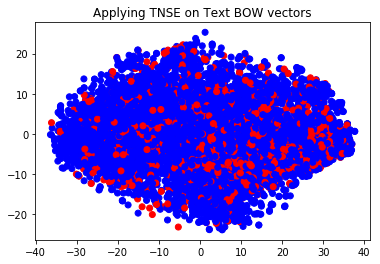

In [50]:
# pleasae write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
# https://github.com/pavlin-policar/fastTSNE
import numpy as np
from openTSNE import TSNE

x, y = BOW_tsvd, reviews_label

BOW_tsne = TSNE( n_components=2, perplexity=80, learning_rate=200, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=1000)

X_embedding = BOW_tsne.fit(x)
y = y.as_matrix(columns=None) #Conversion of Series to matrices https://stackoverflow.com/a/44239421

for_tsne = np.hstack((X_embedding, y.reshape(-1, 1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','label'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['label'].apply(lambda x: colors[x]))
plt.title('Applying TNSE on Text BOW vectors')
plt.show()

**Observation:**

1. This model BOW, Bag of words it is basically used to represent the review text that describes the occurence of each unique words within it.


2. Here, we observe that we can't separate the positive review blue data points and negative review red data point form the total review text.


3. Basically, we count or measure the presence of each the unique words and create a set of distinct meaningful elements (uni-grams).

In [51]:
print('X_embedding Shape: ')
print(X_embedding.shape)
print('*'*50)
print('y Shape: ')
print(y.shape)
print('*'*50)

X_embedding Shape: 
(6000, 2)
**************************************************
y Shape: 
(6000,)
**************************************************


## [5.2] Applying TNSE on Text TFIDF vectors

In [52]:
type(final_tf_idf)

scipy.sparse.csr.csr_matrix

In [53]:
#https://github.com/terodea/Amazon-Fine-Food-Reviews

'''STANDARDIZATION'''

from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler(with_mean=False).fit_transform(final_tf_idf)
print(standardized_data.shape)

(6000, 4268)


In [54]:
#https://github.com/terodea/Amazon-Fine-Food-Reviews

'''SINCE *final_counts* is sparse matrix TruncatedSVD is best suitable.'''
from sklearn.decomposition import TruncatedSVD
tf_idf = TruncatedSVD(n_components=50, random_state=0).fit_transform(standardized_data)

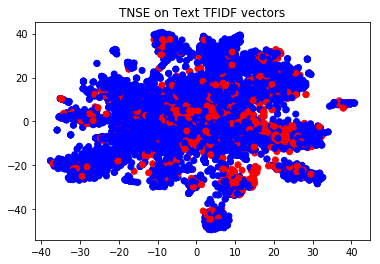

In [55]:
# # please write all the code with proper documentation, and proper titles for each subsection
# # when you plot any graph make sure you use 
#     # a. Title, that describes your plot, this will be very helpful to the reader
#     # b. Legends if needed
#     # c. X-axis label
#     # d. Y-axis label
#     # https://github.com/pavlin-policar/fastTSNE

x, y = tf_idf, reviews_label

tfidf_tsne = TSNE( n_components=2, perplexity=80, learning_rate=200, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=1000)

X_embedding = tfidf_tsne.fit(x)
y = y.as_matrix(columns=None) #https://stackoverflow.com/a/44239421

for_tsne = np.hstack((X_embedding, y.reshape(-1, 1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','label'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['label'].apply(lambda x: colors[x]))
plt.title('TNSE on Text TFIDF vectors')
plt.show()

**Observation :**

1. This model TF IDF, Term frequence - Inverse document frequency it is basically used for information retrieval intented to reflect how important a word is to a doc/review text in a collection or corpus.


2. Here, we observe that we can't separate the positive review blue data points and negative review red data point form the total review text.


3. Basically, the tf–idf value increases proportionally to the number of times a word appears in the doc/review text and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. 

## [5.3] Applying TNSE on Text Avg W2V vectors

In [56]:
type(sent_vectors) 

list

In [57]:
avg_w2v_matrix = np.asmatrix(sent_vectors)
print(avg_w2v_matrix.shape)

(6000, 50)


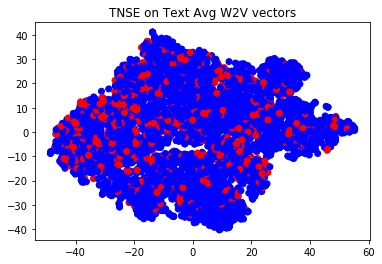

In [58]:
# # please write all the code with proper documentation, and proper titles for each subsection
# # when you plot any graph make sure you use 
#     # a. Title, that describes your plot, this will be very helpful to the reader
#     # b. Legends if needed
#     # c. X-axis label
#     # d. Y-axis label
    
x, y = avg_w2v_matrix, reviews_label

avg_w2v_model = TSNE( n_components=2, perplexity=80, learning_rate=200, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=1000)

X_embedding = avg_w2v_model.fit(avg_w2v_matrix)
y = y.as_matrix(columns=None) #https://stackoverflow.com/a/44239421

for_tsne = np.hstack((X_embedding, y.reshape(-1, 1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','label'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['label'].apply(lambda x: colors[x]))
plt.title('TNSE on Text Avg W2V vectors')
plt.show()

**Observation :**

1. This model  Avg W2V vectors, Average Word2Vec it is basically a Simple way to leverage Word2Vec to build Sentence as Vector. So here whole sentence convert into a vector.


2. Here, we observe that we can't separate the positive review blue data points and negative review red data point form the total review text.


3. Basically, the Avg W2V vectors assumes all words have same weightage and it also take the words semantics into consideration. 

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [59]:
type(tfidf_sent_vectors)

list

In [60]:
tfidf_w2v_matrix = np.asmatrix(tfidf_sent_vectors)
print(tfidf_w2v_matrix.shape)

(6000, 50)


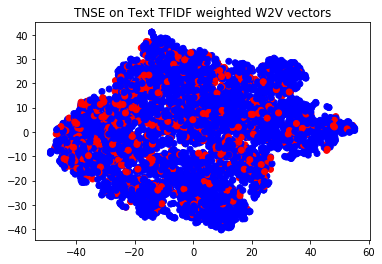

In [61]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

x, y = tfidf_w2v_matrix, reviews_label

tfidf_w2v_tsne = TSNE( n_components=2, perplexity=80, learning_rate=200, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=1000)

X_embedding = tfidf_w2v_tsne.fit(avg_w2v_matrix)
y = y.as_matrix(columns=None) #https://stackoverflow.com/a/44239421

for_tsne = np.hstack((X_embedding, y.reshape(-1, 1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','label'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['label'].apply(lambda x: colors[x]))
plt.title('TNSE on Text TFIDF weighted W2V vectors')
plt.show()
    

**Observation :**

1. This model TFIDF weighted W2V vectors, Term frequence - Inverse document frequency Word2Vec Vector it is basically Perform similar as  Avg W2V vectors.


2. Here, we observe that we can't separate the positive review blue data points and negative review red data point form the total review text.


3. Basically, the TFIDF weighted W2V vectors it take convert whole sentence into vectors and take the words semantics into consideration but unlike  Avg W2V vectors it measure every word's weightage.

## Conclusion :

1. All the positive review blue data points and negative review red data points are look like they merged with each other so we are unable to separate them.


2. But, from the Observation we found that the Avg Word2Vec model abd TF-IDF weighted Word2Vec model performed better then BOW and TF-IDF model as, the outlier data point reduces in the last two Algorithms.


3. The last two Algorithms, Avg Word2Vec model abd TF-IDF weighted Word2Vec also take the words semantics or keep that words having same sematics in consideration.